In [1]:
import os
import numpy as np
from sisl import *
import matplotlib.pyplot as plt



In [8]:
h2o2 = Geometry([[-1.5, 0, 0], [-2.3, -0.6, 0], [0, 0, 0], [0.8, 0.6, 0.]],
               [Atom('O'), Atom('H'), Atom('O'), Atom('H')],
               sc=SuperCell(10, origin=[-5] * 3))

In [9]:
print(h2o2)

Geometry{na: 4, no: 4,
 Atoms{species: 2,
  Atom{O, Z: 8, mass(au): 15.99940, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 2,
  Atom{H, Z: 1, mass(au): 1.00794, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 2,
 },
 maxR: -1.00000,
 SuperCell{nsc: [1 1 1],
  A=[10.000, 0.000, 0.000],
  B=[0.000, 10.000, 0.000],
  C=[0.000, 0.000, 10.000],
 }
}


<AxesSubplot: xlabel='Ang', ylabel='Ang'>

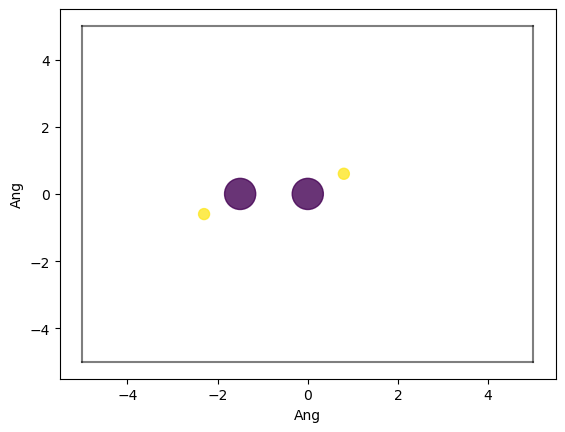

In [10]:
plot(h2o2)

In [11]:
open('RUN.fdf', 'w').write("""%include STRUCT.fdf
SystemLabel siesta_1
PAO.BasisSize SZP
MeshCutoff 250. Ry
CDF.Save true
CDF.Compress 9
SaveHS true
SaveRho true
""")
h2o.write('STRUCT.fdf')

In [12]:
fdf = get_sile('RUN.fdf')
H = fdf.read_hamiltonian()
# Create a short-hand to handle the geometry
h2o2 = H.geometry
print(H)

Hamiltonian{non-zero: 1296, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 4, no: 36,
  Atoms{species: 2,
   Atom{O, Z: 8, mass(au): 16.00000, maxR: 2.08350,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 1.749, q0: 2.0}},
    AtomicOrbital{2sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 1.3285, q0: 0.0}},
    AtomicOrbital{2pyZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2pzZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2pxZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2pyZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.3621, q0: 0.0}},
    AtomicOrbital{2pzZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.3621, q0: 0.0}},
    AtomicOrbital{2pxZ2, q0: 0.0, SphericalOrbital{l: 1, R: 1.3621, q0: 0.0}},
    AtomicOrbital{3dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.0835000000000004, q0: 0.0}},
    AtomicOrbital{3dyzZ1P

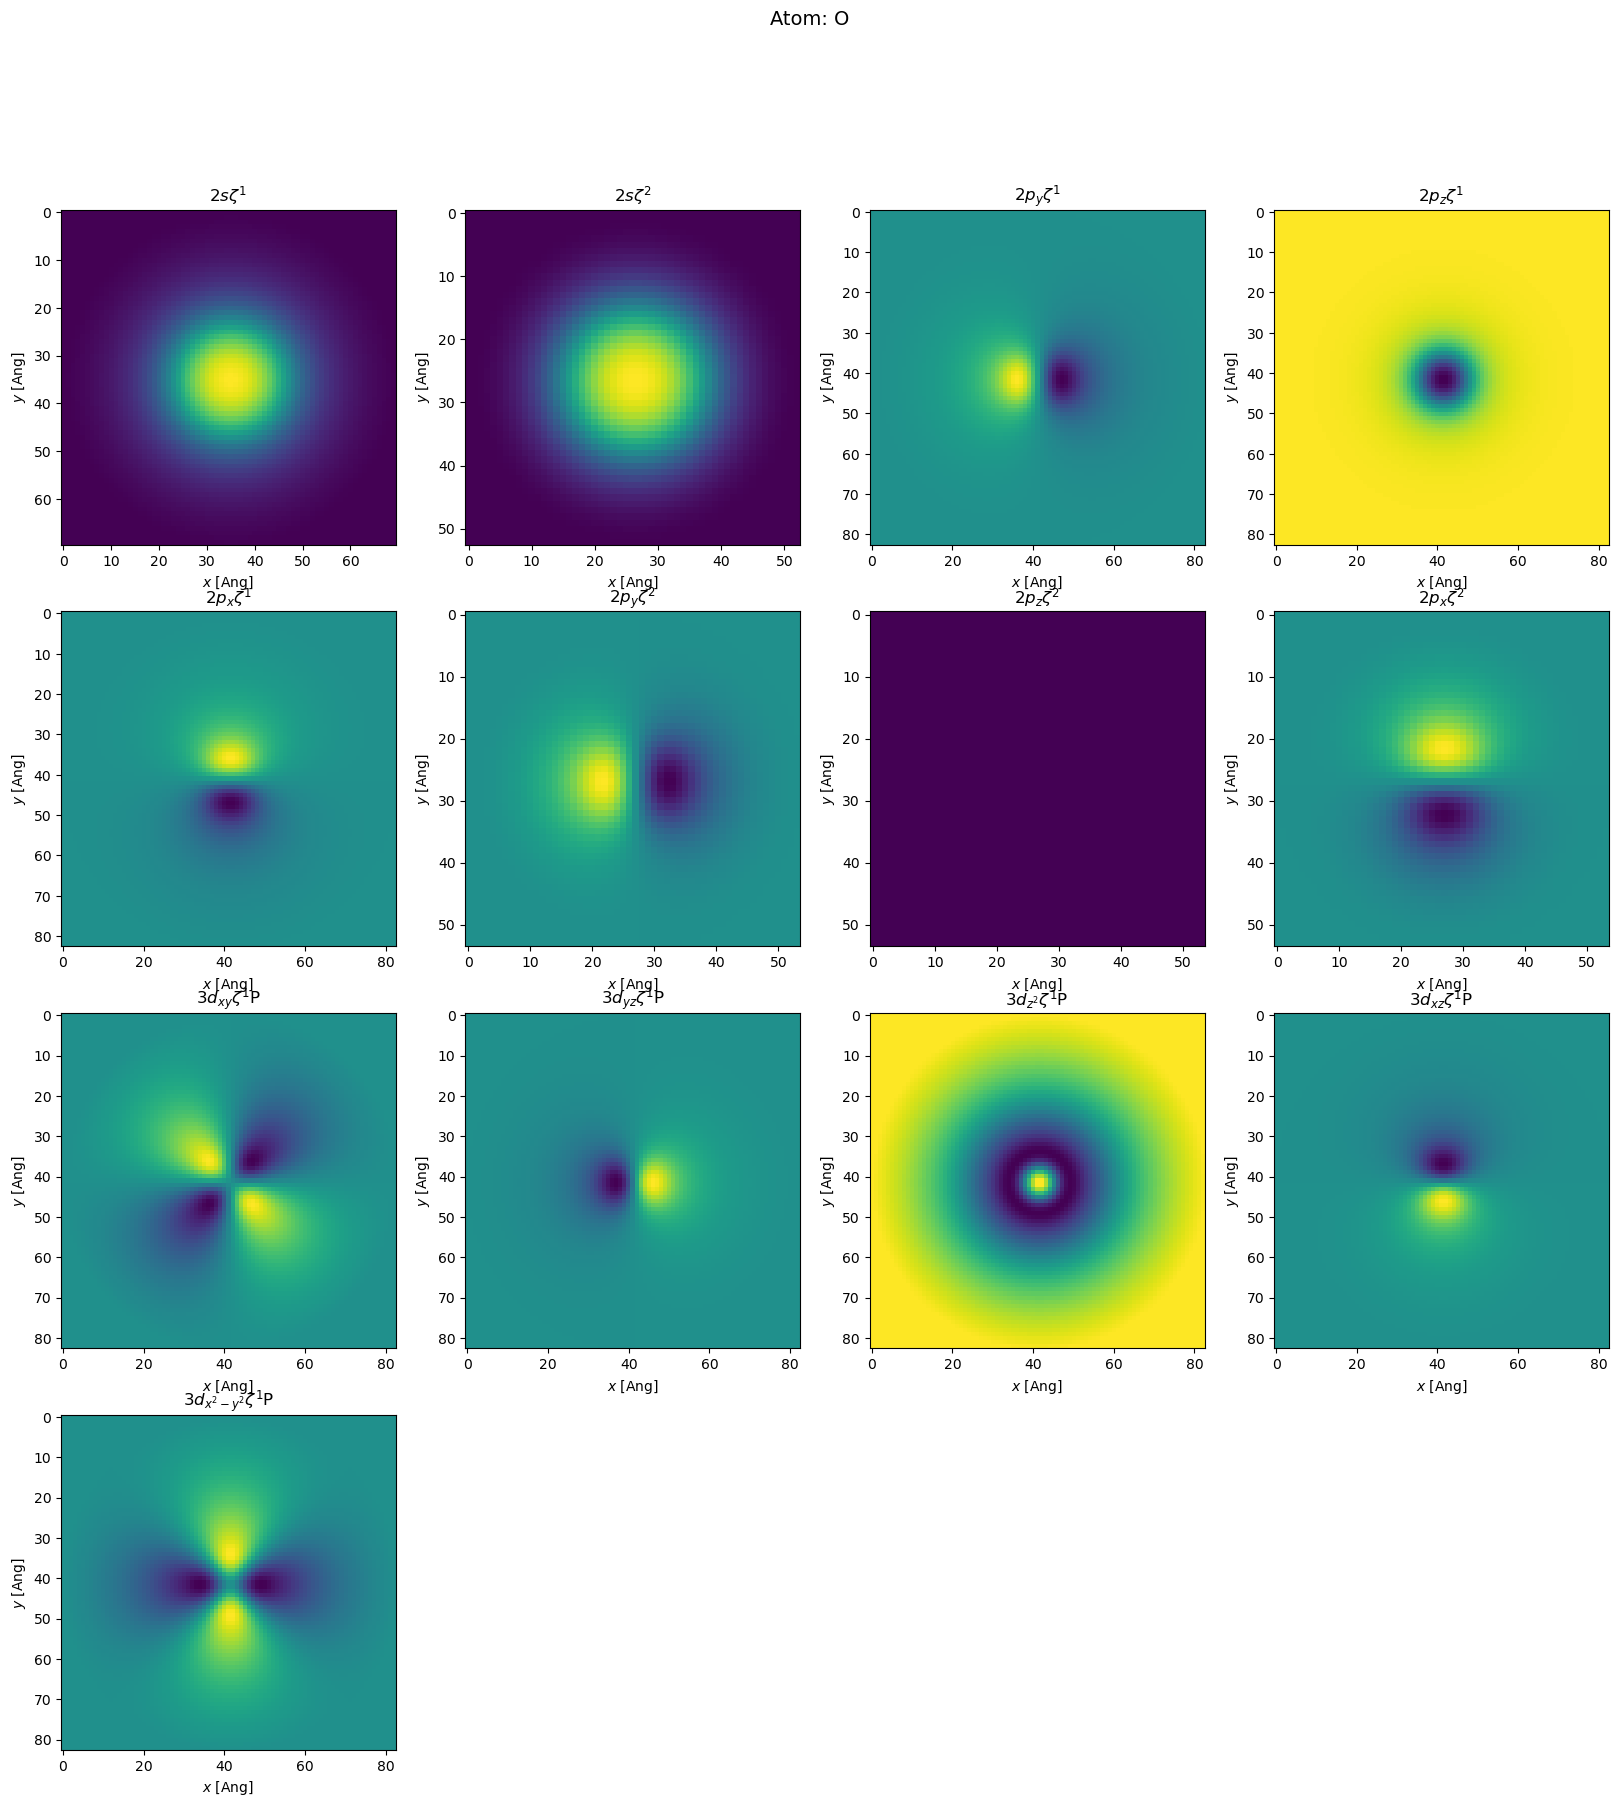

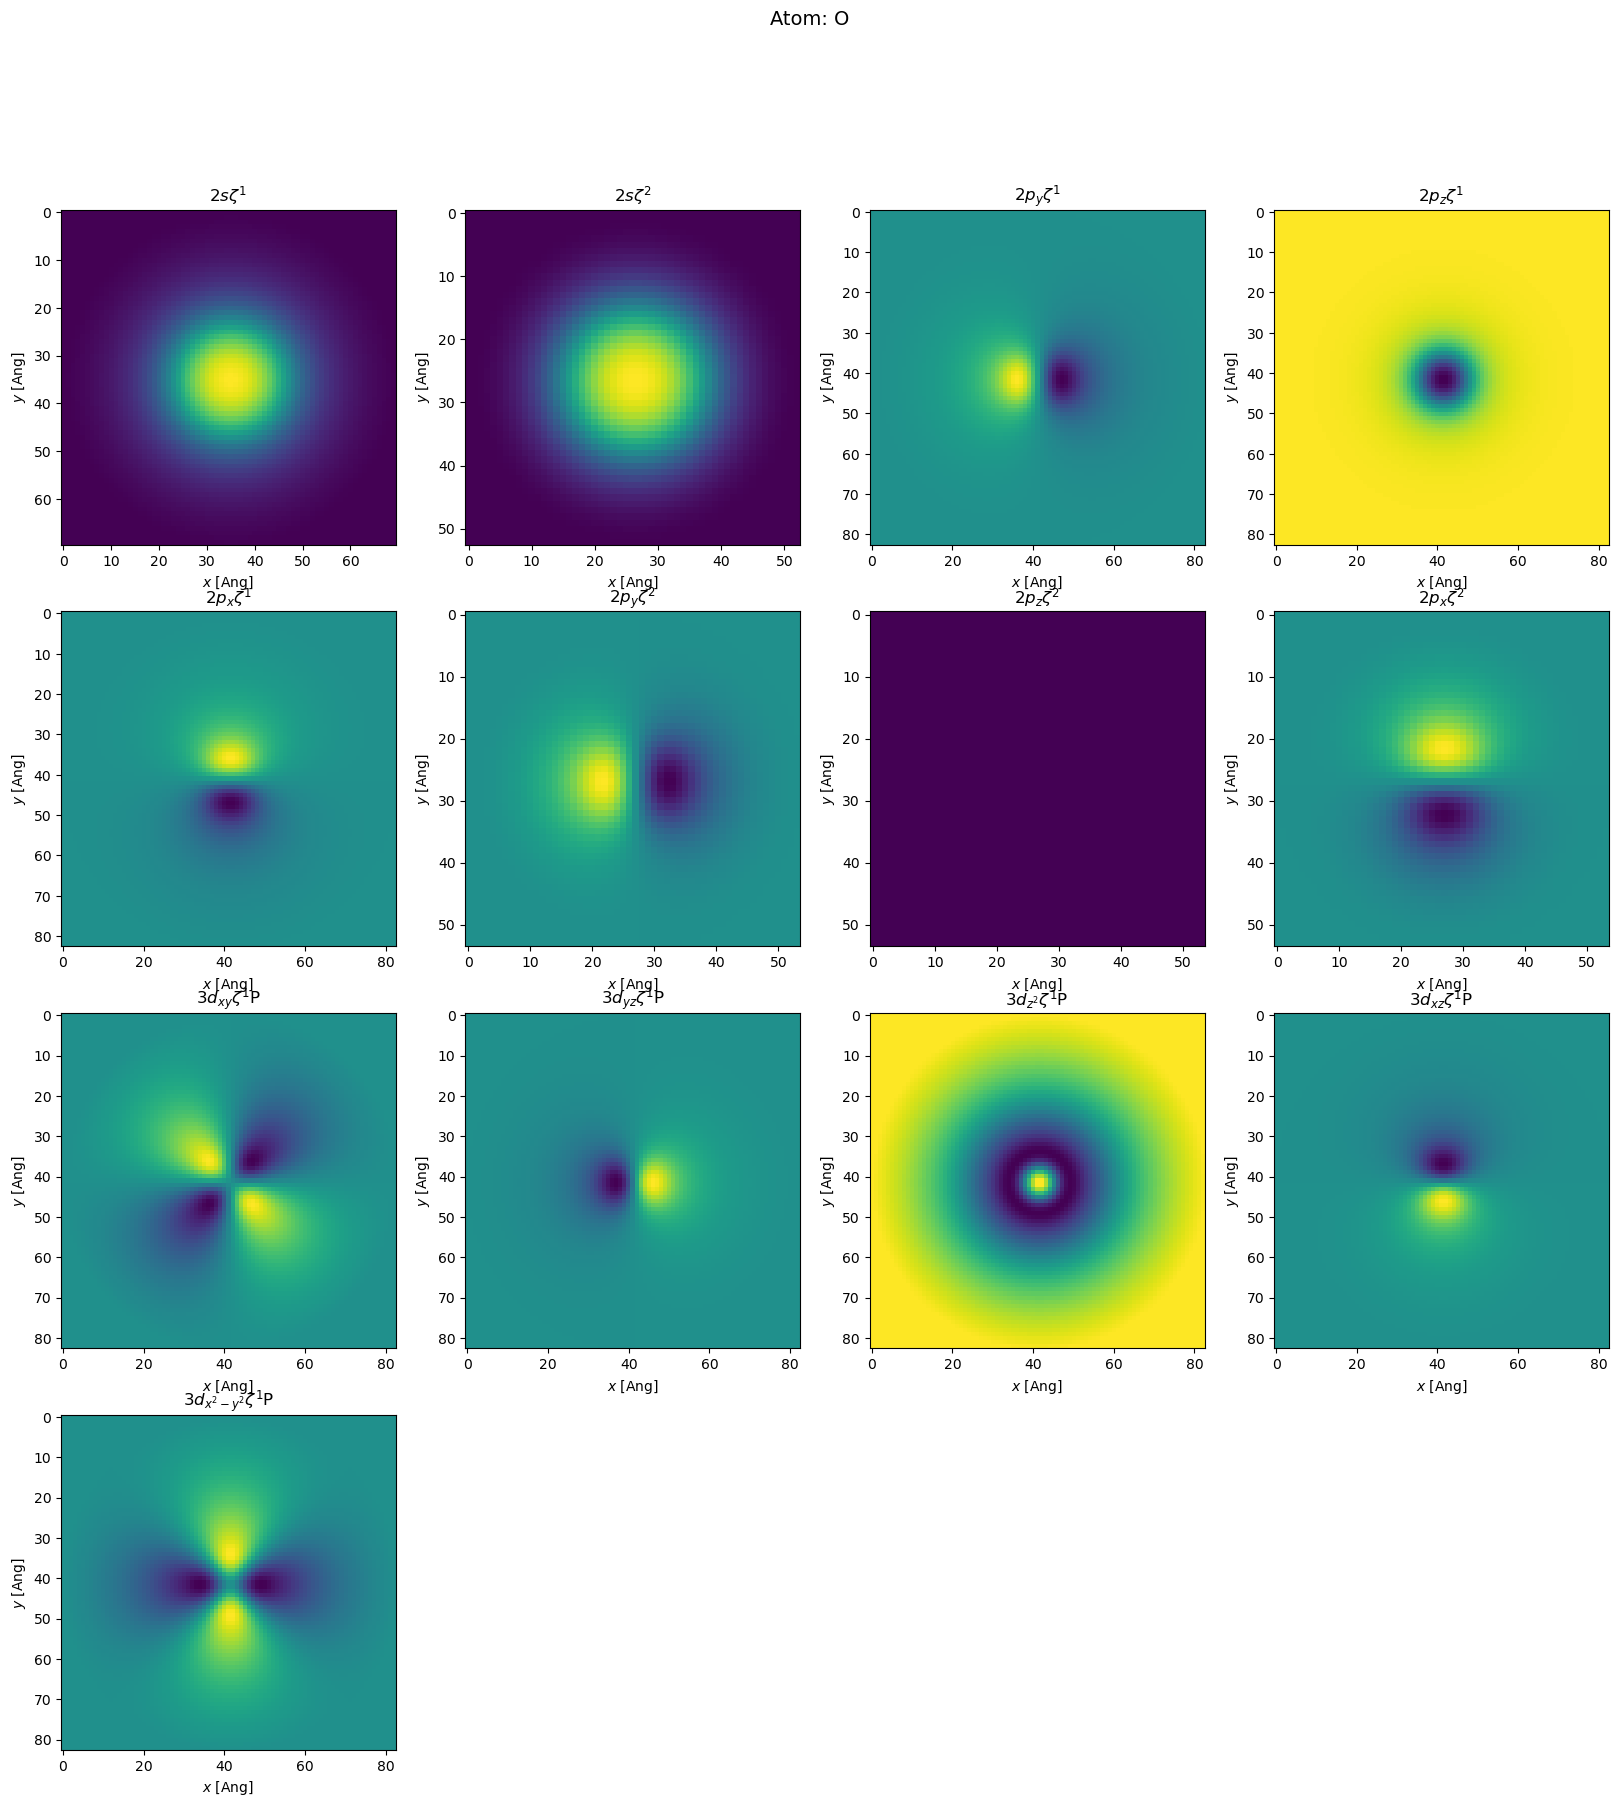

In [14]:
def plot_atom(atom):
    no = len(atom) # number of orbitals
    nx = no // 4
    ny = no // nx
    if nx * ny < no:
        nx += 1
    fig, axs = plt.subplots(nx, ny, figsize=(20, 5*nx))
    fig.suptitle('Atom: {}'.format(atom.symbol), fontsize=14)
    def my_plot(i, orb):
        grid = orb.toGrid(atom=atom)
        # Also write to a cube file
        grid.write('{}_{}.cube'.format(atom.symbol, orb.name()))
        c, r = i // 4, (i - 4) % 4
        if nx == 1:
            ax = axs[r]
        else:
            ax = axs[c][r]
        ax.imshow(grid.grid[:, :, grid.shape[2] // 2])
        ax.set_title(r'${}$'.format(orb.name(True)))
        ax.set_xlabel(r'$x$ [Ang]')
        ax.set_ylabel(r'$y$ [Ang]')
    i = 0
    for orb in atom:
        my_plot(i, orb)
        i += 1
    if i < nx * ny:
        # This removes the empty plots
        for j in range(i, nx * ny):
            c, r = j // 4, (j - 4) % 4
            if nx == 1:
                ax = axs[r]
            else:
                ax = axs[c][r]
            fig.delaxes(ax)
        plt.draw()
plot_atom(h2o2.atoms[0])
plot_atom(h2o2.atoms[1])

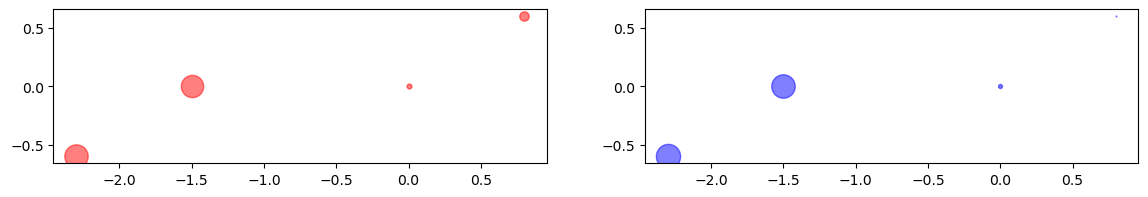

In [21]:
es = H.eigenstate()

# We specify an origin to center the molecule in the grid
h2o2.sc.origin = [-4, -4, -4]

# Reduce the contained eigenstates to only the HOMO and LUMO
# Find the index of the smallest positive eigenvalue
idx_lumo = (es.eig > 0).nonzero()[0][0]
es = es.sub([idx_lumo - 1, idx_lumo])
_, ax = plt.subplots(1, 2, figsize=(14, 2));
for i, (norm2, color) in enumerate(zip(es.norm2(sum=False), 'rbg')):
    for ia in h2o2:
        ax[i].scatter(h2o2.xyz[ia, 0], h2o2.xyz[ia, 1], 600 * norm2[h2o2.a2o(ia, True)].sum(), facecolor=color, alpha=0.5);
    

In [22]:
def integrate(g):
    print('Real space integrated wavefunction: {:.4f}'.format((np.absolute(g.grid) ** 2).sum() * g.dvolume))
g = Grid(0.2, sc=h2o2.sc)
es.sub(0).wavefunction(g)
integrate(g)
#g.write('HOMO.cube')
g.fill(0) # reset the grid values to 0
es.sub(1).wavefunction(g)
integrate(g)
#g.write('LUMO.cube')

Real space integrated wavefunction: 1.0001
Real space integrated wavefunction: 1.0002


In [23]:
DM = fdf.read_density_matrix()
rho = get_sile('siesta_1.nc').read_grid('Rho')



In [24]:
DM_rho = rho.copy()
DM_rho.fill(0)
DM.density(DM_rho)
diff = DM_rho - rho
print('Real space integrated density difference: {:.3e}'.format(diff.grid.sum() * diff.dvolume))

Real space integrated density difference: -1.431e+00
